# Análisis de textos

In [142]:
import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay,
    roc_auc_score, precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline

In [143]:
import warnings
import matplotlib
warnings.filterwarnings("ignore")

In [144]:
# Configuring pandas to show all cell content
pd.set_option("display.max_colwidth", None)

In [145]:
# Downloading stopwords
nltk.download("punkt")
nltk.download("stopwords")
stop_words = stopwords.words("spanish")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\German\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\German\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [146]:
stop_words

['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro'

In [147]:
fakes_df = pd.read_csv("../data/cat_6716.csv")

In [148]:
fakes_df.shape

(3000, 2)

In [149]:
fakes_df.sample(5)

,Textos_espanol,sdg
2193,"Resumen Tras décadas de corrupta gobernanza poscolonial, los líderes africanos reconocieron colectivamente que la buena gobernanza era un requisito previo para la renovación de África y exigía una lucha sin precedentes contra la corrupción imperante en el continente. El Acta Constitutiva de la Unión Africana (AC-UA) incluye la buena gobernanza entre sus objetivos y principios. La buena gobernanza se subrayÃ³ aÃºn mÃ¡s en posteriores instrumentos de la UA adoptados en el marco de la Nueva Alianza para el Desarrollo de Ãfrica (NEPAD) y su Mecanismo Africano de RevisiÃ³n por Pares (APRM). El compromiso de los lÃderes de la UA en la lucha contra la corrupciÃ³n culminÃ³ con la adopciÃ³n de la ConvenciÃ³n de la UniÃ³n Africana para Prevenir y Combatir la CorrupciÃ³n (AUCPCC). Mientras los africanos se preparan para conmemorar la primera dÃ©cada desde la adopciÃ³n de la AUCPCC, este artÃculo reflexiona sobre el cumplimiento de este instrumento por parte de los Estados miembros de la UA, los retos y las perspectivas de Ã©xito de la lucha contra la corrupciÃ³n. Sostiene que, a pesar de algunos progresos realizados, esta lacra sigue sin disminuir...",16
2635,"El derecho internacional incorpora las reglas, principios y procesos que regulan la conducta de los estados y las organizaciones internacionales (Higgins, 1994, 2-3). Como se discutió en el Capítulo 1, el Capítulo VII de la Carta de la ONU faculta al Consejo de Seguridad para exigir a los estados que restrinjan y prohíban las relaciones económicas con los estados, entidades o individuos objetivo.1 Fuera de la Carta de la ONU u otro tratado aplicable, el derecho internacional consuetudinario del estado la responsabilidad regula cómo y las condiciones bajo las cuales un estado puede imponer sanciones económicas.",16
2603,"Los tratados de control de armamentos son necesarios para reducir los grandes arsenales de armas nucleares que constituyen uno de los mayores peligros para el mundo. Sin embargo, un tratado impactante depende de ejercicios de inspección efectivos para verificar el cumplimiento de los términos del tratado por parte de los participantes. Dichos procedimientos requerirían la verificación de la autenticidad de una ojiva en proceso de desmantelamiento. Las soluciones propuestas anteriormente carecían de la combinación de sensibilidad isotópica y seguridad de la información. Aquí presentamos la prueba de viabilidad experimental de una técnica que utiliza resonancias nucleares inducidas por neutrones y es sensible a la combinación de isótopos y geometría. La información se cifra físicamente para evitar la fuga de información sensible. Nuestro enfoque puede aumentar significativamente la confiabilidad de los futuros tratados de control de armas al tiempo que amplía su alcance para incluir el desmantelamiento verificado de las propias ojivas nucleares.",16
1603,"Por ejemplo, podría haber acuerdo en que las energías renovables constituyen productos fitosanitarios basados en la fuente de energía (es decir, el recurso) y no en el uso de los productos, ya que su categorización no se basa tanto en la categoría específica de tecnologías (por ejemplo, motores generadores de electricidad, convertidores de potencia o inversores) como en la fuente de energía (por ejemplo, biocombustibles, energía hidráulica de baja altura, solar, eólica o geotérmica). Otros productos que utilizan una fuente de energía concreta podrían clasificarse como una única fuente dentro de una categoría (por ejemplo, los coches o trenes eléctricos, que entran dentro del SA 8703 o el SA 8601). Sin embargo, la mayoría de estos bienes deben su comportamiento medioambiental a una combinación de características, y sólo pueden identificarse definitivamente mediante ensayos.",7
923,"Todos los usuarios de agua urbana cuentan con medidores y los precios del agua se cobran de acuerdo con el volumen consumido. Desde la introducción de la política, los precios del agua han aumentado sustancialmente

In [150]:
fakes_df["sdg"].value_counts(dropna=False, normalize=True)

sdg
6     0.333333
7     0.333333
16    0.333333
Name: proportion, dtype: float64

In [151]:
fakes_df["Textos_espanol"] = fakes_df["Textos_espanol"].astype(str)

In [152]:
# The param 'stratify' is useful to guarantee label proportions on train and test sets
X_train, X_test, y_train, y_test = train_test_split(fakes_df[["Textos_espanol"]], fakes_df["sdg"], test_size=0.3, stratify=fakes_df["sdg"], random_state=1)

In [153]:
X_train.shape, X_test.shape

((2100, 1), (900, 1))

In [154]:
pd.Series(y_train).value_counts(normalize=True)

sdg
7     0.333333
6     0.333333
16    0.333333
Name: proportion, dtype: float64

In [155]:
pd.Series(y_test).value_counts(normalize=True)

sdg
6     0.333333
7     0.333333
16    0.333333
Name: proportion, dtype: float64

## Text vectorization

In [156]:
bow = CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)

In [157]:
X_bow = bow.fit_transform(X_train["Textos_espanol"])

In [158]:
print("Vocabulary size:", len(bow.vocabulary_))

Vocabulary size: 18518


In [159]:
tfidf = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)

In [160]:
X_tfidf = tfidf.fit_transform(X_train["Textos_espanol"])

In [161]:
print("Vocabulary size:", len(tfidf.vocabulary_))

Vocabulary size: 18518


## Training a model with BoW

In [162]:
bow_model = RandomForestClassifier(random_state=2)

In [163]:
bow_model.fit(X_bow, y_train)

RandomForestClassifier(random_state=2)

<Axes: >

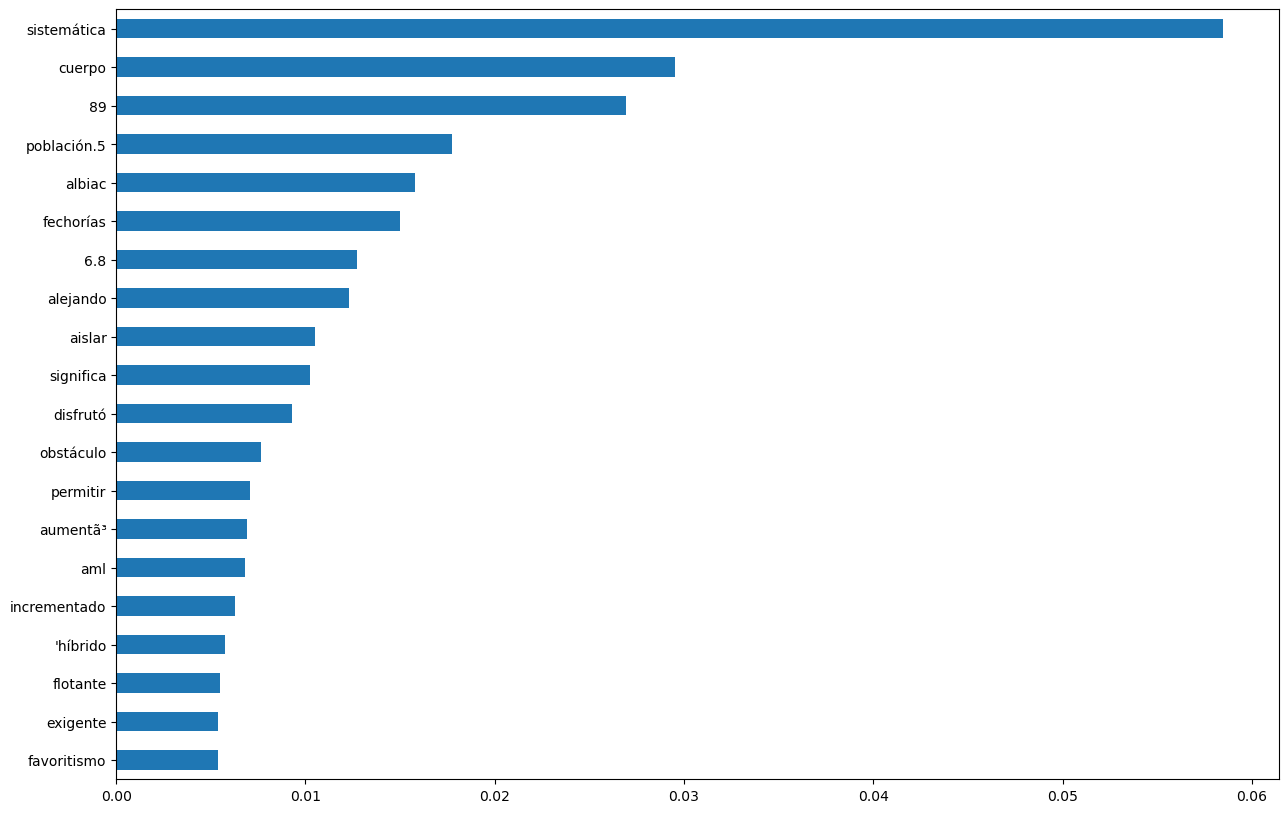

In [164]:
# Feature importance in tree models is an indicator on how relevant is a feature for taking the decision by the model
pd.Series(bow_model.feature_importances_, index=bow.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

In [165]:
bow_estimators = bow_model.estimators_
print("Number of trees:", len(bow_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in bow_estimators]))

Number of trees: 100
Trees depth (mean): 94.2


In [166]:
y_train_bow_predict = bow_model.predict(X_bow)
y_test_bow_predict = bow_model.predict(bow.transform(X_test["Textos_espanol"]))

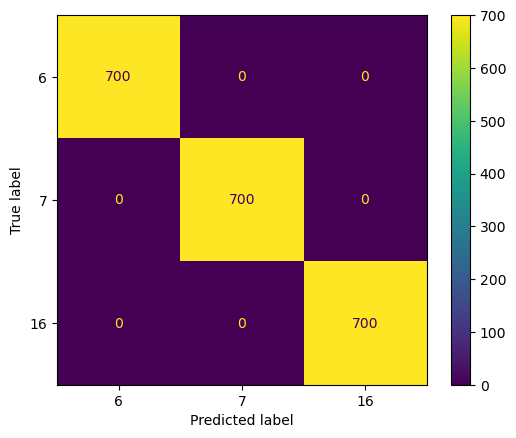

In [167]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

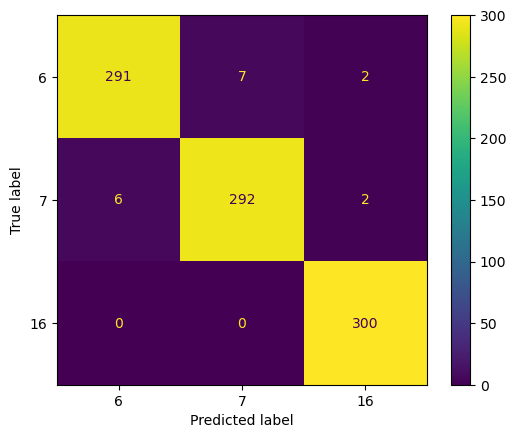

In [168]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [169]:
print("Precision:", precision_score(y_train, y_train_bow_predict, average="weighted"))
print("Recall:", recall_score(y_train, y_train_bow_predict, average="weighted"))
print("F1:", f1_score(y_train, y_train_bow_predict, average="weighted"))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [170]:
print("Precision:", precision_score(y_test, y_test_bow_predict, average="weighted"))
print("Recall:", recall_score(y_test, y_test_bow_predict, average="weighted"))
print("F1:", f1_score(y_test, y_test_bow_predict, average="weighted"))

Precision: 0.9810762379412264
Recall: 0.9811111111111112
F1: 0.9810700396919866


## Training a model with TF-IDF

In [171]:
tfidf_model = RandomForestClassifier(random_state=3)

In [172]:
tfidf_model.fit(X_tfidf, y_train)

RandomForestClassifier(random_state=3)

<Axes: >

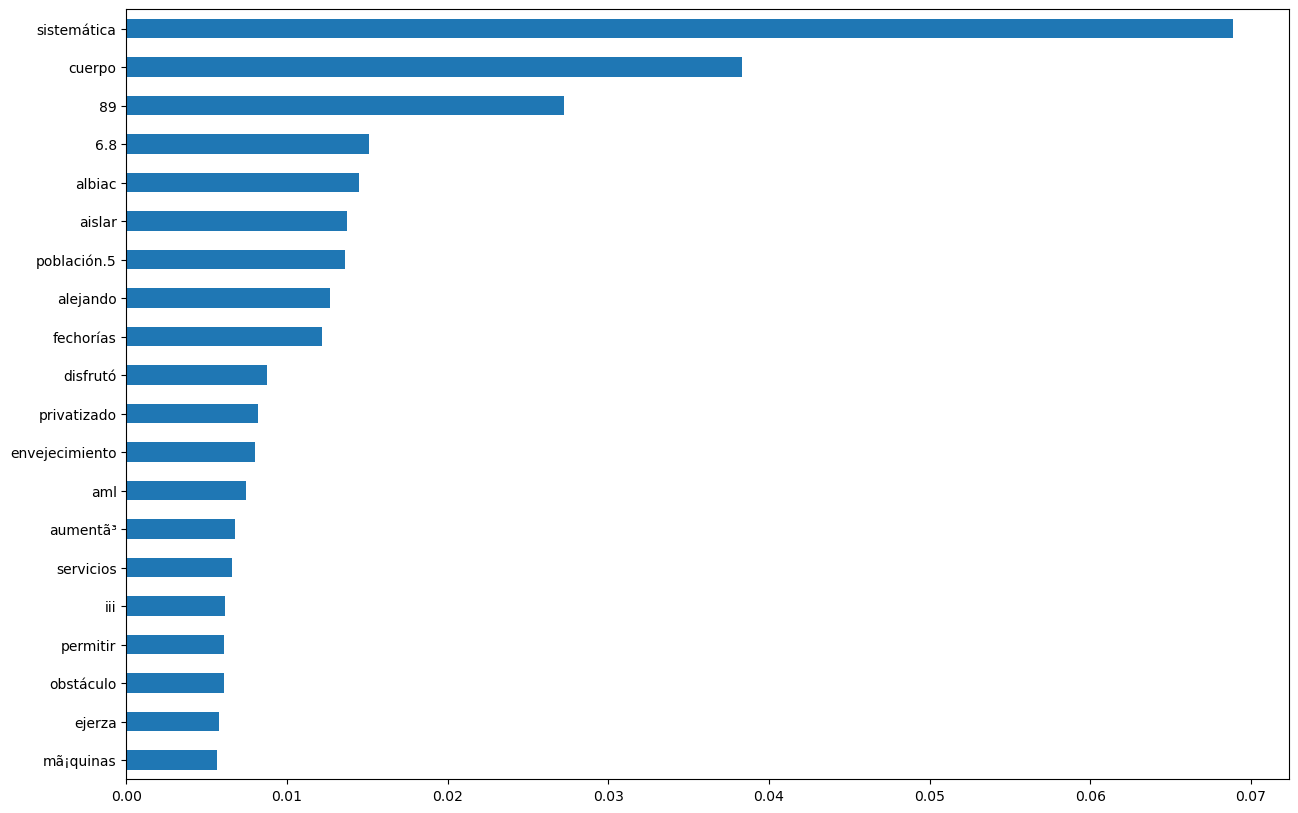

In [173]:
pd.Series(tfidf_model.feature_importances_, index=tfidf.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

In [174]:
tfidf_estimators = tfidf_model.estimators_
print("Number of trees:", len(tfidf_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in tfidf_estimators]))

Number of trees: 100
Trees depth (mean): 85.96


In [175]:
y_train_tfidf_predict = tfidf_model.predict(X_tfidf)
y_test_tfidf_predict = tfidf_model.predict(tfidf.transform(X_test["Textos_espanol"]))

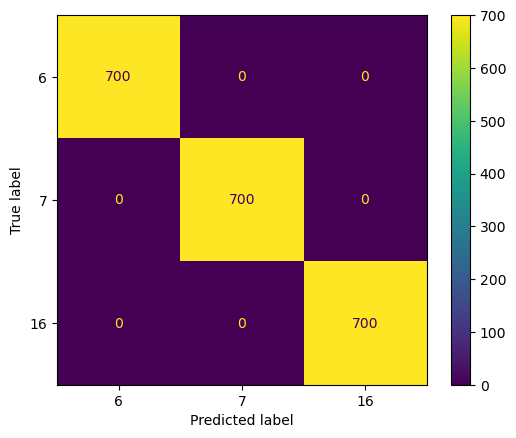

In [176]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

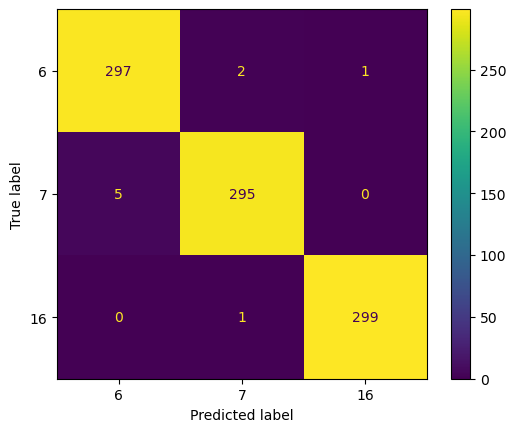

In [177]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [178]:
print("Precision:", precision_score(y_train, y_train_tfidf_predict, average="weighted"))
print("Recall:", recall_score(y_train, y_train_tfidf_predict, average="weighted"))
print("F1:", f1_score(y_train, y_train_tfidf_predict, average="weighted"))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [179]:
print("Precision:", precision_score(y_test, y_test_tfidf_predict, average="weighted"))  
print("Recall:", recall_score(y_test, y_test_tfidf_predict, average="weighted"))
print("F1:", f1_score(y_test, y_test_tfidf_predict, average="weighted"))

Precision: 0.9900144203939928
Recall: 0.99
F1: 0.9899999012334705


### Model selection

In [180]:
pipeline = Pipeline(steps = [
    ("vectorizer", CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)),
    ("classifier", RandomForestClassifier(random_state=4))
])

In [181]:
param_grid = {
    "vectorizer": [CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words), TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words)],
    "vectorizer__lowercase": [True, False],
    "classifier__n_estimators": [50, 100],
    "classifier__criterion": ['gini', 'entropy'],
    "classifier__max_depth": [25, 50, 75, 100]
}

In [182]:
search = RandomizedSearchCV(pipeline, param_grid, n_iter=10, scoring=["precision", "recall", "f1"], refit="f1", cv=10, return_train_score=True, verbose=1, random_state=5)

In [184]:
search.fit(X_train["Textos_espanol"], y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


KeyboardInterrupt: 

In [ ]:
search.best_params_

In [ ]:
search.best_score_

In [ ]:
y_train_search_predict = search.best_estimator_.predict(X_train["Textos_espanol"])
y_test_search_predict = search.best_estimator_.predict(X_test["Textos_espanol"])

In [ ]:
print("Precision:", precision_score(y_train, y_train_search_predict, average="weighted"))
print("Recall:", recall_score(y_train, y_train_search_predict, average="weighted"))
print("F1:", f1_score(y_train, y_train_search_predict, average="weighted"))

In [ ]:
print("Precision:", precision_score(y_test, y_test_search_predict, average="weighted"))
print("Recall:", recall_score(y_test, y_test_search_predict, average="weighted"))
print("F1:", f1_score(y_test, y_test_search_predict, average="weighted"))